In [131]:
import urllib.request
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 800)

import functools
import datetime
import statistics
import json

## Request Prostitution-related Data from the WPRDC API

In [4]:
# Base URL suggested by WPRDC
# url = 'https://data.wprdc.org/api/3/action/datastore_search?resource_id=e03a89dd-134a-4ee8-a2bd-62c40aeebc6f&limit=5&q=title:jones'  

In [6]:
req_limit = 32000 # number of records to pull
test_url = 'https://data.wprdc.org/api/3/action/datastore_search?resource_id=e03a89dd-134a-4ee8-a2bd-62c40aeebc6f&q={"OFFENSES":"5902"}&limit='+str(req_limit)

In [8]:
r = requests.get(test_url).json()
r['success']

True

In [9]:
r


{'help': 'https://data.wprdc.org/api/3/action/help_show?name=datastore_search',
 'success': True,
 'result': {'include_total': True,
  'limit': 32000,
  'q': {'OFFENSES': '5902'},
  'records_format': 'objects',
  'resource_id': 'e03a89dd-134a-4ee8-a2bd-62c40aeebc6f',
  'total_estimation_threshold': None,
  'records': [{'_id': 73054,
    'PK': '2047953',
    'CCR': '22063258',
    'AGE': 39,
    'GENDER': 'M',
    'RACE': 'B',
    'ARRESTTIME': '2022-05-18T11:30:00',
    'ARRESTLOCATION': 'Zone 1',
    'OFFENSES': '3304 Criminal Mischief. / 5902(a)(1) Prostitution  / 3124.1 Sexual Assault / 5902(b) Promoting Prostitution / 5902(b)(1) Promoting Prostitution - Keeping Business or House / 5902(b)(3) Promoting Prostitution - Causing another to become or remain  / 5902(b)(7) Permitting place to be regularly used for prostitution / 5902(b)(8) Prostitution - receiving benefit from / 3121(a)(3) Rape of unconscious person / 3123(a)(3) IDSI with unconscious person / 3126(a)(4) Indecent assault of

In [10]:
export_file = True
export_fn = 'arrests_data_'+datetime.date.today().isoformat()+'.json'

if export_file:
    with open(export_fn, "w") as outfile:
        json.dump(r, outfile)

# Format arrest data

In [11]:
data = pd.DataFrame(r['result']['records'])
data = data.set_index('_id')
data.index.rename('id', inplace=True)
data.sample(5)

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y,rank OFFENSES
id,,,,,,,,,,,,,,,,,
41741,2021122,19226199,53.0,F,W,2019-11-05T14:26:00,"Middle ST & Foreland ST Pittsburgh, PA 15212",5902(a)(1) Prostitution / 5902(a)(2) Prostitution - Loitering for purpose of,"Middle ST & Foreland ST Pittsburgh, PA 15212",East Allegheny,1,2304,1,1,-79.999393,40.454577,0.070624
45499,2024344,20025157,52.0,M,B,2020-02-05T19:15:00,"Middle ST & Foreland ST Pittsburgh, PA 15212",902 Criminal Solicitation. / 5902(e) Patronizing a Prostitute,"Middle ST & Foreland ST Pittsburgh, PA 15212",East Allegheny,1,2304,1,1,-79.999393,40.454577,0.057309
66982,2042732,21191483,34.0,F,W,2021-10-19T07:10:00,"Howard ST & E North AV Pittsburgh, PA 15212",5902(a)(1) Prostitution / 13(a)(32) Paraphernalia - Use or Possession / 5902(a)(2) Prostitution - Loitering for purpose of,"East Ohio ST & James ST Pittsburgh, PA 15212",East Allegheny,1,2304,1,1,-80.000605,40.453486,0.070624
11607,1989111,17150466,42.0,F,W,2017-08-09T18:45:00,"East ST & Royal ST Pittsburgh, PA 15212",5902(a)(1) Prostitution / 5902(a)(2) Prostitution - Loitering for purpose of,"East ST & Royal ST Pittsburgh, PA 15212",Spring Hill-City View,1,2620,1,1,-79.999747,40.465978,0.070624
36438,2016382,19139511,57.0,M,B,2019-07-15T18:42:00,"Forbes AV & Van Braam ST Pittsburgh, PA 15219",902 Criminal Solicitation. / 5902(e) Patronizing a Prostitute,"Forbes AV & Van Braam ST Pittsburgh, PA 15219",Bluff,2,103,6,3,-79.982674,40.437559,0.057309


### Categorize prostitution-related charges

In [12]:
charges_dict = {
    "providers" : {
        "5902\s?\(a\)": 'Prostitution',
        "5902\s?\(a\)\(1\)": 'Prostitution',
        "5902\s?\(a\)\(2\)": 'Prostitution - Loitering for',
    },
    "third-party" : {
        "5902\s?\(b\)": 'Promoting',
        "5902\s?\(b\)\(1\)": 'Promoting - Keeping house or business for ',
        "5902\s?\(b\)\(2\)": 'Promoting - Finding brothelworker',
        "5902\s?\(b\)\(3\)": 'Promoting - Encouraging',
        "5902\s?\(b\)\(4\)": 'Promoting - Soliciting patron for',
        "5902\s?\(b\)\(5\)": 'Promoting - Procuring prostitute for patron',
        "5902\s?\(b\)\(6\)": 'Promoting - Transporting for',
        "5902\s?\(b\)\(7\)": 'Promoting - Leasing or regular use of place',
        "5902\s?\(b\)\(8\)": 'Promoting - Receiving benefit',
        "5902\s?\(d\)": 'Living off prostitutes',
    },
    "clients": {   
        "5902\s?\(e\)": 'Patronizing prostitutes',
    }
}

charges_by_p = {
    "providers" : ["5902(a)", "5902(a)(1)", "5902(a)(2)"],
    "third-party" : ["5902(b)(1)", "5902(b)(2)", "5902(b)(3)", "5902(b)(4)", "5902(b)(5)", "5902(b)(6)", "5902(b)(7)", "5902(b)(8)", "5902(d)"], 
    "clients" : ["5902(e)"]
}

In [13]:
## Add boolean column for each type of charge
provider_mask = data.OFFENSES.str.contains('|'.join(charges_dict["providers"]))
third_mask = data.OFFENSES.str.contains('|'.join(charges_dict["third-party"]))
client_mask = data.OFFENSES.str.contains('|'.join(charges_dict["clients"]))

data["ISPROVIDER"] = provider_mask
data["ISTHIRDPARTY"] = third_mask
data["ISCLIENT"] = client_mask

In [14]:
# Examine overlap in types of charges
data[["ISTHIRDPARTY", "ISPROVIDER", "ISCLIENT"]].value_counts()

ISTHIRDPARTY  ISPROVIDER  ISCLIENT
False         True        False       460
              False       True        176
True          False       False        53
              True        False        16
False         True        True          2
Name: count, dtype: int64

### Convert data types, replace missing values

In [15]:
## Convert date format
data.ARRESTTIME = pd.to_datetime(data.ARRESTTIME)

## Add year & month column for convenience
data["YEAR"] = data.ARRESTTIME.dt.year
data["MONTH"] = data.ARRESTTIME.dt.month

## Covnert offense string to list
data["OFFENSES_STR"] = data.OFFENSES.copy()
data.OFFENSES = data.OFFENSES.apply(lambda offs: [off.strip() for off in offs.split(" / ")])

In [16]:
## Fill missing values with NaN 
data.AGE = data.AGE.replace(0.0, np.nan)


### Approximate missing location coordinates
Sex crimes are only recorded with the incident police zone for privacy reasons. 

This section steals some helpful [code from Matthew McCarroll](https://medium.com/@matthewjmccarroll/analysis-of-crime-in-pittsburgh-pennsylvania-using-python-and-pandas-efebdd90c51c).


In [17]:
# From Matthew McCarroll
# 1
# Latitude: 40.4569565
# Longitude: -80.0160637
# 2
# Latitude: 40.4435808
# Longitude: -79.9800111
# 3
# Latitude: 40.421685
# Longitude: -79.9924763
# 4
# Latitude: 40.4414787
# Longitude: -79.9212047
# 5
# Latitude: 40.4742729
# Longitude: -79.9091618
# 6
# Latitude: 40.4420734
# Longitude: -80.0322484
#
# OSC - Outside City. Assign to Nevilla Island for sake of visualization
# 
X_coord = {'Zone 1': -80.0160637 , 'Zone 2': -79.9800111, 'Zone 3': -79.9924763, 'Zone 4':-79.9212047 ,
           'Zone 5':-79.9091618 , 'Zone 6':-80.0322484, 'OSC' :  40.497685 } # OSC = Outside. Assign to Neville Island
Y_coord = {'Zone 1': 40.4569565, 'Zone 2': 40.4435808 , 'Zone 3': 40.421685, 'Zone 4': 40.4414787 ,
           'Zone 5': 40.4742729, 'Zone 6':40.4420734, 'OSC' : -80.085561 } # OSC = Outside. Assign to Neville Island
# map zone coordinates to all incident locations labeled with a zone description.
# if not 'zone', puts NaN                      
data['ZONEX'] = data['INCIDENTLOCATION'].map(X_coord)
data['ZONEY'] = data['INCIDENTLOCATION'].map(Y_coord)
# fills in x,y coordinates of zone incident locations
num_missing_pre = data['X'].isna().sum()
data['X']=data['X'].fillna(data['ZONEX'], axis=0)
data['Y']=data['Y'].fillna(data['ZONEY'], axis=0)
num_missing_post = data['X'].isna().sum()

# remove ZONEX and ZONEY columns
data = data.drop(['ZONEX'], axis=1)
data = data.drop(['ZONEY'], axis=1)
print(num_missing_pre - num_missing_post, "coordinates filled")
print(num_missing_post, "coordinates are still missing")

31 coordinates filled
46 coordinates are still missing


In [18]:
# For incidents outside city without coordinates, put them all on Neville Island just for sake of visualization
out_X = 40.497685 # Neville Island
out_Y = -80.085561 # Neville Island
osc_keys = ["Outside City", "OSC", "None"]

# If Zone or Neighborhood is outside city & coordinates are missing, set coordinates to Neville Island
data["ISOUT"] = data.INCIDENTNEIGHBORHOOD.map(lambda neigh: neigh in osc_keys)
#data["ISOUT2"] = data["ISOUT"]|data["INCIDENTZONE"].map(lambda zone: zone == 'OSC')
data["ISOUTX"] = data["ISOUT"].map(lambda out: out_X if out else np.nan)
data["ISOUTY"] = data["ISOUT"].map(lambda out: out_Y if out else np.nan)
data = data.drop(['ISOUT'], axis=1)
#data = data.drop(['ISOUT2'], axis=1)

data["X"] = data["X"].fillna(data['ISOUTX'], axis=0)
data["Y"] = data["X"].fillna(data['ISOUTX'], axis=0)
data = data.drop(['ISOUTX'], axis=1)
data = data.drop(['ISOUTY'], axis=1)

print(len(data.loc[data.X == out_X]), "coordinates were set to Neville Island.")
print(len(data.loc[data.X.isna()]), "coordinates are still missing.")

4 coordinates were set to Neville Island.
42 coordinates are still missing.


In [19]:
# We're still missing a bunch of coordinates even for places with valid locations/neighborhoods? Maybe just be input errors?
# I'll just assign their coordinates based on the Incident Zone, because all the data seems to have a valid Incident Zone

                                                                                                   
X_coord = {'1': -80.0160637 , '2': -79.9800111, '3': -79.9924763, '4':-79.9212047 ,
           '5':-79.9091618 , '6':-80.0322484, 'OSC' :  40.497685 }
Y_coord = {'1': 40.4569565, '2': 40.4435808 , '3': 40.421685, '4': 40.4414787 ,
           '5': 40.4742729, '6':40.4420734, 'OSC' : -80.085561 }

# map zone coordinates to all arrest with valid incident zones but missing coordinates
# if not 'zone', puts NaN                      
data['ZONEX'] = data['INCIDENTZONE'].map(X_coord)
data['ZONEY'] = data['INCIDENTZONE'].map(Y_coord)
# fills in x,y coordinates of zone incident locations
num_missing_pre = data['Y'].isna().sum()
data['X']=data['X'].fillna(data['ZONEX'], axis=0)
data['Y']=data['Y'].fillna(data['ZONEY'], axis=0)
num_missing_post = data['Y'].isna().sum()

# remove ZONEX and ZONEY columns
data = data.drop(['ZONEX'], axis=1)
data = data.drop(['ZONEY'], axis=1)
print(num_missing_pre - num_missing_post, "coordinates filled")
print(num_missing_post, "coordinates are still missing")

42 coordinates filled
0 coordinates are still missing


In [20]:
# Are any important columns still missing values?
# A: yes. Council districts are probably calculated from X,Y, so any XY that was missing cannot be filled.
print("Total number of missing values", data.apply(pd.DataFrame.isna).sum().sum())
data.apply(pd.DataFrame.isna).sum()

Total number of missing values 265


PK                        0
CCR                       0
AGE                       9
GENDER                    0
RACE                      0
ARRESTTIME                0
ARRESTLOCATION            0
OFFENSES                  0
INCIDENTLOCATION          0
INCIDENTNEIGHBORHOOD     32
INCIDENTZONE              0
INCIDENTTRACT            32
COUNCIL_DISTRICT         96
PUBLIC_WORKS_DIVISION    96
X                         0
Y                         0
rank OFFENSES             0
ISPROVIDER                0
ISTHIRDPARTY              0
ISCLIENT                  0
YEAR                      0
MONTH                     0
OFFENSES_STR              0
dtype: int64

In [21]:
# Fill missing neighborhoods & council districts with "Unknown" 
data.loc[data.INCIDENTNEIGHBORHOOD.isna()]
data["INCIDENTNEIGHBORHOOD"] = data["INCIDENTNEIGHBORHOOD"].fillna("Unknown")
data["COUNCIL_DISTRICT"] = data["COUNCIL_DISTRICT"].fillna("Unknown")
data["INCIDENTTRACT"] = data["COUNCIL_DISTRICT"].fillna("Unknown")
data["PUBLIC_WORKS_DIVISION"] = data["COUNCIL_DISTRICT"].fillna("Unknown")

# TODO later there's probably an API to get a council district based on coordinates. I could also guess at council district based on police zone? 

### Filter by dates
In fall 2023, the police department migrated their arrest data to a new platform. As of Feburary 2024, the data is still not publicly documented or easily accessible. It's unclear whether the partial data from 2023 is complete, so let's filter it out. 



In [23]:
start_date = "2016-01-01"
end_date = "2023-01-01"
#end_date = pd.Timestamp.today()

data = data.loc[(data.ARRESTTIME > start_date) & (data.ARRESTTIME < end_date)]

In [24]:
base_data = data.copy()

# About this data

This data comes from the Western Pennsylvania Regional Data Center. It represents arrests made by or within the *city of Pittsburgh*. This data does not usually represent arrests made by Allegheny County police or by police in the surrounding boroughs. 

### Q: How many prostitution-related arrests were made (2016-2022)?

A: There are 695 (and counting) arrests available in this dataset. We include any charges under 5902, the PA state statute that includes charges related to prostitution (providing sex work), being a patron (a john/customer), or promoting prosititution (assisting in prostitution, pimping, running a brothel, etc). These charges are not focused on sex trafficking, sexual assault, or coercion.   

In [81]:
len(base_data)

695

### Q: What data is available?
A: The location and time of arrests, the location of incidents, and the demographics of the arrested person are available. 
* Gender (M/F/Unknown) 
* Race (White, Black, Asian, Hispanic?, Other? Unknown, Indigenous/American Indian? These labels aren't documented, so I'm guessing)
* Age
* Arrest date & time
* Charges brought (OFFENSES)
* Location of arrest: address of the block. sometimes arrests happen after an incident occurs.(ARRESTLOCATION)
* Location of incident: address of the block (INCIDENTLOCATION)
* Location of incident: coordinates of the block (X, Y)
* Incident Neighborhood (INCIDENTNEIGHBORHOOD)
* Incident Police Zone # (INCIDENTZONE)
* Incident Census tract # (INCIDENTTRACT)
* Council District (presumably where indicent took place, but it's not documented)
* Public Works [division #](https://gis.pittsburghpa.gov/pghzoning/) (presumably where indicent took place, but it's not documented)
* multiple anonymous IDs (ARREST_ID, 	CC 	Incident Numbe)r
* something called"rankOFFENSESS" that isn't documented. Not sure what it means

What is not available:
* identifying information about each arrest (e.g., we don't know if someone has been arrested multiple times)
* the outcome of the arrest (e.g., whether the person was convicted, the charges thrown out, jail time
* Arrests before 2016

(In theory, prostitution-related charges could be charged as summary violations, and would not appear in the arrest dataset. As of Dec 2023, there were no prostitution-related charges in the [Non-Traffic Citation dataset](https://data.wprdc.org/dataset/non-traffic-citations/resource/6b11e87d-1216-463d-bbd3-37460e539d86), indicating that prostitution is being charged as a misdemeanor. ))

In [82]:
data.columns

Index(['PK', 'CCR', 'AGE', 'GENDER', 'RACE', 'ARRESTTIME', 'ARRESTLOCATION',
       'OFFENSES', 'INCIDENTLOCATION', 'INCIDENTNEIGHBORHOOD', 'INCIDENTZONE',
       'INCIDENTTRACT', 'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION', 'X', 'Y',
       'rank OFFENSES', 'ISPROVIDER', 'ISTHIRDPARTY', 'ISCLIENT', 'YEAR',
       'MONTH', 'OFFENSES_STR', 'DATE', 'GROUPARREST', 'ARRESTSESSION'],
      dtype='object')

# Questions - people arrested for prostitution

### Q: How many people were arrested for Prostitution from 2016-2022?

A: Over 470 prostitution arrests were made in the last 7 years. 

Note: It seems like occasionally police tack on a prostitution charge (5902(a)) for any charges related to prostitution/soliciting/promotion. 
Note: Data is only available after 2016

In [83]:
#start_date = "2016-01-01"
#end_date = "2023-01-01"
#end_date = pd.Timestamp.today()

#data = data.loc[(data.ARRESTTIME > start_date) & (data.ARRESTTIME < end_date)]
output = data.loc[data.ISPROVIDER][["YEAR"]]
print("Total: ", output.value_counts().sum())
pd.DataFrame(output.value_counts(sort=False))

Total:  471


,count
YEAR,
2016,45
2017,106
2018,105
2019,109
2020,64
2021,21
2022,21


### Q: What are the demographics of those arrested for prostitution?

#### Age
Arrested people range from age 17 to age 88. The average age is 35. Two arrests were under the age of 18. A small number of people have unknown ages. 

#### Race
51% of arrestees were White. 41% were Black. 4% were Asian, 1% were Hispanic. The remaining 3% were Unknown or Other races. 

The 2022 American Community Survey census estimated that Pittsburgh is approximately 64% White, 19%-24% Black, indicating that Black people are disproportionately arrested for prostitution.
https://censusreporter.org/profiles/16000US4261000-pittsburgh-pa/

#### Gender
84% were Female. 15% Male. 1% had Unknown.

This data only includes F/M/Unknown labels. We don't know how police decide to label the gender of transgender arrestees. 0.81.3


In [152]:
providers = data.loc[data.ISPROVIDER]

           # Arrested for prositution
Age                                  
17                                  2
18s & 20s                         162
30s                               172
40s                                82
50s                                38
60+                                 8
Unknown                             7


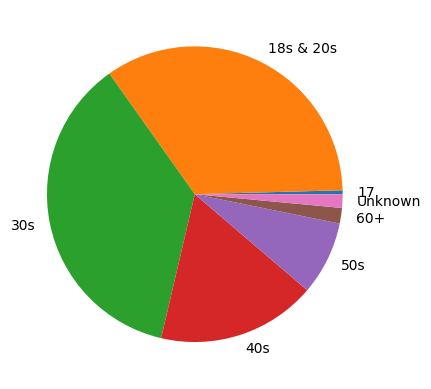

In [163]:
age_labels = ["17", "18s & 20s", "30s", "40s", "50s", "60+", "Unknown"]
age_bins = [0,17,29,39,49,59,120]
pie_vals = np.append(providers.AGE.value_counts(bins=age_bins, sort=False, dropna=True).values, providers.AGE.isna().sum())
plt.pie(pie_vals, labels=age_labels)
print(pd.DataFrame({"# Arrested for prositution":pie_vals, "Age" : age_labels}).set_index('Age'))

min     17.0
max     88.0
mean    34.8
Name: AGE, dtype: float64

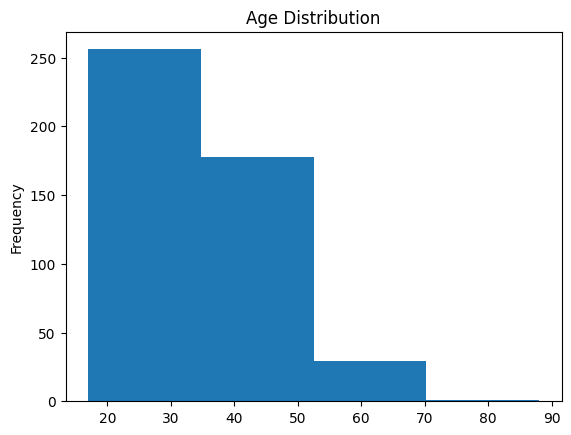

In [86]:
# Min, max, Average age of arrest
providers.AGE.plot(kind='hist', title="Age Distribution", bins=4)
providers.AGE.apply([min, max, pd.DataFrame.mean]).round(1)

In [33]:
## Examine the Under 18 arrests
# providers.loc[providers.AGE < 18]

In [34]:
## Race by percentage
providers.RACE.value_counts(normalize=True).round(3)*100

RACE
W    51.6
B    41.2
A     3.4
H     1.3
U     1.3
O     1.3
Name: proportion, dtype: float64

In [35]:
# Gender by percentage
providers.GENDER.value_counts(normalize=True).round(3)*100

GENDER
F    84.1
M    15.1
U     0.8
Name: proportion, dtype: float64

# Location

Notes on location data: 
* This data can only tell us what locations police choose to make arrests. It doesn't necessarily tell us where prostitution happens in the city.
* Many locations are missing or approximated in this data. Most arrests are reported at the block level.
* According to [WPRDC Documentation](https://wiki.tessercat.net/wiki/Crime,_Courts,_and_Corrections:Arrests), sex crimes have only the police zone to protect victim confidentiality. Most of these types of charges (e.g., exploiting minors, trafficking) are brought against third parties, so incidents that involve third party arrests are more likely to have Unknown locations.
* Sometimes arrests are made within the city for incidents that happened outside Pittsburgh. These are labeled "OSC" Zone or "Unknown" neighborhood.
* For the sake of visualization, I assigned the lat/long coordinates of Unknown or Outside City arrests to sit on Neville Island. 

### Q: Which neighborhoods have prostitution-related incidents?

A: Arrests are clustered around East Allegheny (31%, part of Zone 1) and in downtown Pittsburgh (26%, aka the Central Business District, Zone 2). 
Another 5% are in the Bluff (bordering Downtown). The rest of the incident locations are scattered across the city. 

In [36]:
data.columns

Index(['PK', 'CCR', 'AGE', 'GENDER', 'RACE', 'ARRESTTIME', 'ARRESTLOCATION',
       'OFFENSES', 'INCIDENTLOCATION', 'INCIDENTNEIGHBORHOOD', 'INCIDENTZONE',
       'INCIDENTTRACT', 'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION', 'X', 'Y',
       'rank OFFENSES', 'ISPROVIDER', 'ISTHIRDPARTY', 'ISCLIENT', 'YEAR',
       'MONTH', 'OFFENSES_STR'],
      dtype='object')

In [158]:
# Top-10 neighborhoods where incidents occur
top_n = 10
print("incident neighborhoods, %")
data[["INCIDENTNEIGHBORHOOD"]].value_counts(normalize=True).head(top_n).round(3)*100

incident neighborhoods, %


INCIDENTNEIGHBORHOOD     
East Allegheny               30.9
Central Business District    26.0
Bluff                         4.9
Unknown                       4.5
Homewood North                3.2
Carrick                       2.4
Spring Hill-City View         2.3
Allegheny Center              2.2
Homewood South                2.0
South Oakland                 1.9
Name: proportion, dtype: float64

In [38]:
# Zones where incidents occur
print("incident police zone, %")
data[["INCIDENTZONE"]].value_counts(normalize=True).round(3)*100

incident police zone, %


INCIDENTZONE
1               41.6
2               34.4
3                8.9
5                6.3
4                5.0
6                2.9
OSC              0.9
Name: proportion, dtype: float64

### Q: What are the top repeat locations for each zone/neighborhood?
A: 

#### Zone 1 - North Side / Brighton Heights / Spring Hill
Incidents are clustered heavily between E Ohio and E North near the parkway in East Allegheny. This is a popular spot for street work- probably the closest area that Pittsburgh has to a blade. 

#### Zone 2 - Downtown / Strip / Lawrenceville
 * 600 Commonwealth / Commonwealth & Liberty is Point State Park / Convention Center / Wyndham Grand hotel.
 * 100 Washington is PPG Arena & Downtown Marriot hotel.
 * Bigelow Sq is DoubleTree hotel

#### Zone 3 - South Side / Carrick / Mt Washington
Three arrests in Station Square

1900 Block Brownsville - ? 

#### Zone 4  - Oakland / Sq Hill / Shadyside / New Homestead
Clusters around the riverfront area near Hot Metal Bridge in South Oakland

#### Zone 5 - Homewood / Garfield / East Lib
N Homewood & Frankstown / 7200 Block Idlewild St  are near Homewood Gazebo Park and Homewood House. 

7700 Block Bennett ST - ?

#### Zone 6 - Brookline / Beechview / Sheradon / E Carnegie
1100 Block Banksville Rd is a cluster of hotels (Comfort Inn, Days Inn) in Banksville

#### Outside City
A handful of arrests represent incidents outside the city.11

In [39]:
# TOP LOCATIONS BY ZONE
top_n = 5 # ignore locations that only show up a few times
for zone in data.INCIDENTZONE.unique():
    print("ZONE", zone, "Top Locations")
    print(data.loc[data.INCIDENTZONE == zone]["INCIDENTLOCATION"].value_counts(sort=True).head(top_n))
    print()

ZONE 1 Top Locations
INCIDENTLOCATION
Middle ST & Foreland ST Pittsburgh, PA 15212    96
E North AV & Howard ST Pittsburgh, PA 15212     19
Zone 1                                          16
Foreland ST & Middle ST Pittsburgh, PA 15212    16
East ST & Royal ST Pittsburgh, PA 15212         13
Name: count, dtype: int64

ZONE 2 Top Locations
INCIDENTLOCATION
600 Block Commonwealth PL Pittsburgh, PA 15222       70
100 Block Washington PL Pittsburgh, PA 15219         42
Bigelow SQ Pittsburgh, PA 15219                      18
Commonwealth PL & Liberty AV Pittsburgh, PA 15222    17
Liberty AV & Commonwealth PL Pittsburgh, PA 15222    15
Name: count, dtype: int64

ZONE 4 Top Locations
INCIDENTLOCATION
300 Block Technology DR Pittsburgh, PA 15219           9
300 Block Technology Center DR Pittsburgh, PA 15219    5
5100 Block Ladora WY Pittsburgh, PA 15207              3
200 Block Technology Center DR Pittsburgh, PA 15213    2
Zone 4                                                 2
Name: count,

In [40]:
# TOP LOCATIONS BY NEIGHBORHOOD
# I didn't analyze these much
top_n = 10 # ignore neighborhoods that aren't common 
top_n_loc = 3 # ignore locations that only show up a few times
for neigh in data[["INCIDENTNEIGHBORHOOD"]].value_counts().head(top_n).index:
    print(neigh[0], "Top Locations")
    print(data.loc[data.INCIDENTNEIGHBORHOOD == neigh[0]]["INCIDENTLOCATION"].value_counts(sort=True).head(top_n_loc))
    print()

East Allegheny Top Locations
INCIDENTLOCATION
Middle ST & Foreland ST Pittsburgh, PA 15212    96
E North AV & Howard ST Pittsburgh, PA 15212     19
Foreland ST & Middle ST Pittsburgh, PA 15212    16
Name: count, dtype: int64

Central Business District Top Locations
INCIDENTLOCATION
600 Block Commonwealth PL Pittsburgh, PA 15222    57
100 Block Washington PL Pittsburgh, PA 15219      42
Bigelow SQ Pittsburgh, PA 15219                   18
Name: count, dtype: int64

Bluff Top Locations
INCIDENTLOCATION
Forbes AV & Moultrie ST Pittsburgh, PA 15219    8
Moultrie ST & Tustin ST Pittsburgh, PA 15219    3
Brady ST & 2nd AV Pittsburgh, PA 15219          3
Name: count, dtype: int64

Unknown Top Locations
INCIDENTLOCATION
Zone 1    16
Zone 2     7
Zone 3     4
Name: count, dtype: int64

Homewood North Top Locations
INCIDENTLOCATION
N Homewood AV & Frankstown AV Pittsburgh, PA 15208    5
7200 Block Idlewild ST Pittsburgh, PA 15208           4
900 Block N Murtland ST Pittsburgh, PA 15208          

### Q: Which council districts have most incidents? 
A: Council Districts 1 (Wilson) and 6 (Lavelle) represent the majority of prostitution-related incidents. 

District 1 has 36%. District 6 represents 28%. Unknown districts make up 14% of incidents, but 2/3 of those Unknown are in Zones 1 or 2, meaning that they could be added to either District 1 or 6 counts. You could estimate that **~73% of incidents happen in either District 1 or 6**. These districts cover most of Dowtown, North Side, and the Bluff. 

District 9 (Burgess) represents 9% of incdients.

In [41]:
# Council people as of Dec 2023
council_num_names = {
    '1': "Wilson",
    '2': "Kail-Smith",
    '3': "Kraus",
    '4': "Coghill",
    '5': "Warwick",
    '6': "Lavelle",
    '7': "Gross",
    '8': "Stassburger",
    '9': "Burgess",
    "Unknown": "Unknown"
}

In [42]:
# Council districts where incidents occur
print("incidents by council district, %")
data[["COUNCIL_DISTRICT"]].replace(council_num_names).value_counts(normalize=True,).round(3)*100

incidents by council district, %


COUNCIL_DISTRICT
Wilson              36.4
Lavelle             27.3
Unknown             13.7
Burgess              8.6
Kraus                5.2
Kail-Smith           3.9
Coghill              2.9
Warwick              1.0
Gross                0.7
Stassburger          0.3
Name: proportion, dtype: float64

In [43]:
# Find the zones of Unknown council districts
print(len(data.COUNCIL_DISTRICT == 'Unknown'), "total incidents were in an Unknown council districts")
print("% of incident in Unknown Council Districts in each police zone:")
data.loc[data.COUNCIL_DISTRICT == 'Unknown'][["COUNCIL_DISTRICT", "INCIDENTZONE"]].value_counts(normalize=True).round(3)*100

695 total incidents were in an Unknown council districts
% of incident in Unknown Council Districts in each police zone:


COUNCIL_DISTRICT  INCIDENTZONE
Unknown           2               37.9
                  1               32.6
                  3               12.6
                  4                7.4
                  OSC              6.3
                  5                2.1
                  6                1.1
Name: proportion, dtype: float64

### Q: Which council districts have the most *recent* incidents? 
A: Similar to overall data, Council Districts 1 (Wilson) and 6 (Lavelle) represent the majority of prostitution-related incidents. District 9 (Burgess) represents a distant third.

In [44]:
# Council districts where incidents occur
year = '2020'
start_date = year+'-01-01'
recent_data = data.loc[(data.ARRESTTIME > start_date)]
print("incidents since", year, "by council district, %")
print(len(recent_data), "total incidents since", year)
recent_data[["COUNCIL_DISTRICT"]].replace(council_num_names).value_counts(normalize=True,).round(3)*100

incidents since 2020 by council district, %
155 total incidents since 2020


COUNCIL_DISTRICT
Wilson              38.1
Unknown             21.9
Lavelle             19.4
Burgess              9.7
Kail-Smith           6.5
Kraus                4.5
Name: proportion, dtype: float64

### Q: Which locations had multiple arrests on a single day, in a single location? 
A: 

Multiple arrests on a single day might suggest a raid. I'll call an "arrest session" any set of arrests that happen on a unique date-location pair. 

A majority of arrests were made to individuals. 77% of arrest sessions led to only 1 person being arrested. 14% arrested two people. The remaining 11% represent sessions where 3+ people were arrested on a given date at a specific location. 

TODO Take a closer look at the specific dates/locations. 

TODO Look at sessions with 2 arrests. Are they arresting provider + client? Or something else? 

Number of people arrested on a given arrest session (%)


count
9     1.0
8     1.0
7     1.0
6     0.0
5     2.0
4     2.0
3     4.0
2    13.0
1    77.0
Name: proportion, dtype: float64

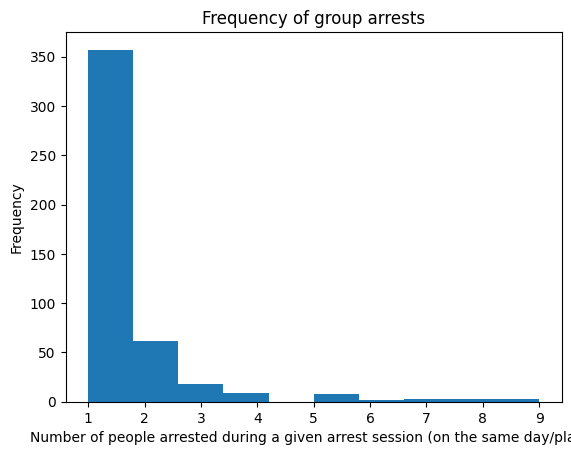

In [45]:
data["DATE"] = data["ARRESTTIME"].apply(pd.Timestamp.date)

arrest_sessions = data[["DATE","INCIDENTLOCATION"]].value_counts()
arrest_sessions_dict = arrest_sessions.to_dict()
group_arrest_col = {}
group_arrest_id_col = {}
for i, row in data.iterrows():
    group_arrest_id_col[i] = (row.DATE, row.INCIDENTLOCATION)
    if (row.DATE, row.INCIDENTLOCATION) in arrest_sessions_dict:
        group_arrest_col[i] = arrest_sessions_dict[(row.DATE, row.INCIDENTLOCATION)]
    else: 
        group_arrest_col[i] = np.nan
        
# Make a column GROUPARREST that holds the count of people arrested at that same date/incident location
# Make a column ARRESTSESSION with tuples (DATE, INCIDENTLOCATION) for utility
data["GROUPARREST"] = group_arrest_col
data["ARRESTSESSION"] = group_arrest_id_col
arrest_sessions.plot(kind="hist", xlabel="Number of people arrested during a given arrest session (on the same day/place)", title="Frequency of group arrests")
print("Number of people arrested on a given arrest session (%)")
arrest_sessions.value_counts(sort=False, normalize=True).round(2)*100

<Axes: xlabel='DATE'>

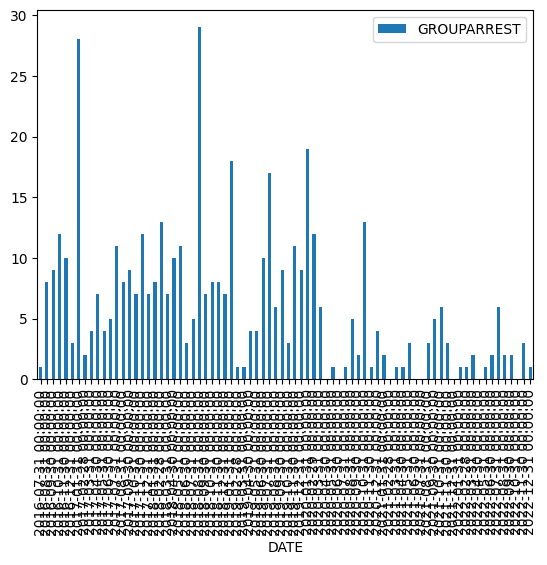

In [67]:
arrest_sessions = data[["DATE","INCIDENTLOCATION", "ARRESTSESSION","GROUPARREST"]].drop_duplicates(subset="ARRESTSESSION")
arrest_sessions.set_index("DATE", inplace=True)
arrest_sessions.index =  pd.to_datetime(arrest_sessions.index)

arrest_sessions.groupby(pd.Grouper(freq='M')).count().plot(kind="bar", y="GROUPARREST")

In [47]:
print("Dates & locations of selected group arrests")
data.loc[data.GROUPARREST >= 4]["ARRESTSESSION"].value_counts()

# Jan 26, 2017 is a Penns Game
# 2018-08-16 is a Pirates Game
# Jan 8, 2020 is "human trafficking sting" 
    # https://cseinstitute.org/human-trafficking-investigation-leads-to-five-prostituted-persons-arrested/
    # https://www.wpxi.com/news/top-stories/10-people-charged-undercover-prostitution-bust/ZJPMWUOQ3ZBRLL2QL3EMEPXJ3U/
# 2019-02-04 ?
# 2019-1-25?

Dates & locations of selected group arrests


ARRESTSESSION
(2018-08-16, Commonwealth PL & Liberty AV Pittsburgh, PA 15222)      9
(2017-01-26, Bigelow SQ Pittsburgh, PA 15219)                        9
(2019-03-04, 600 Block Commonwealth PL Pittsburgh, PA 15222)         9
(2019-07-25, 300 Block Technology DR Pittsburgh, PA 15219)           8
(2019-02-04, 600 Block Commonwealth PL Pittsburgh, PA 15222)         8
(2020-01-08, 1100 Block Banksville RD Pittsburgh, PA 15216)          8
(2019-01-25, 100 Block Washington PL Pittsburgh, PA 15219)           7
(2019-07-02, 100 Block Washington PL Pittsburgh, PA 15219)           7
(2019-01-14, 600 Block Commonwealth PL Pittsburgh, PA 15222)         7
(2019-01-24, 600 Block Commonwealth PL Pittsburgh, PA 15222)         6
(2020-03-09, 600 Block Commonwealth PL Pittsburgh, PA 15222)         6
(2018-02-01, 100 Block Washington PL Pittsburgh, PA 15219)           5
(2017-12-13, Bigelow SQ Pittsburgh, PA 15219)                        5
(2019-01-18, 300 Block Technology Center DR Pittsburgh, PA 1521

<Axes: xlabel='DATE', ylabel='GROUPARREST'>

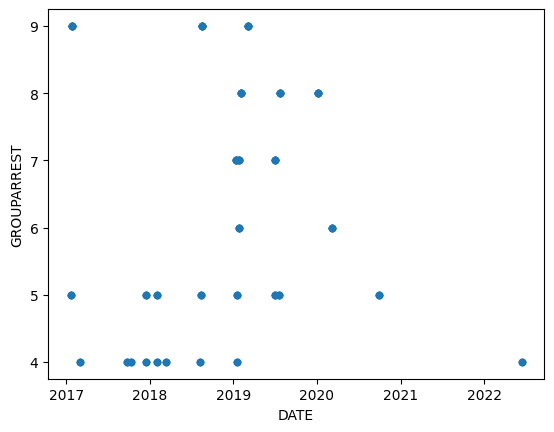

In [48]:
data.loc[data.GROUPARREST >= 4].plot.scatter(x="DATE", y="GROUPARREST")

# Arrests over time

# Did any days have large numbers of arrests?

Yes, more than 

In [49]:
cutoff = 3
time = data.set_index("DATE")
time.index =  pd.to_datetime(time.index)
count_by_date = time.index.value_counts()
#count_by_date.loc[count_by_date > cutoff].count()
count_by_date.describe()

count    313.000000
mean       2.220447
std        1.832566
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        9.000000
Name: count, dtype: float64

# Charges Associated with Prostitution

### Q: What charges are commonly associated with prostitution? 
A: Instruments of crime, criminal solicitation, drug charges, and criminal conspiracy are common cross-charges. 

In [65]:
cutoff = 2 # for space reasons, withhold  charges that show up very infrequently
data.OFFENSES.explode().value_counts().loc[lambda count : count > cutoff]

OFFENSES
5902(a)(1) Prostitution                                                    447
5902(a)(2) Prostitution - Loitering for purpose of                         282
907 Possessing Instruments of Crime.                                       216
902 Criminal Solicitation.                                                 179
5902(e) Patronizing a Prostitute                                           176
13(a)(32) Paraphernalia - Use or Possession                                 81
903 Criminal Conspiracy.                                                    74
13(a)(16) Possession of Controlled Substance                                67
9501 Bench Warrant                                                          42
5902(b) Promoting Prostitution                                              28
5902(b)(6) Transporting for the purpose of engaging in prostitution         22
13(a)(30) Possession w/ Intent to Del. Controlled Substance                 21
5902(b)(1) Promoting Prostitution - Keeping

### Q: How many charges are usually placed?
Most people with a prostitution charge (5902(a)(1)) also pick up 1-2 additional charges. Loitering for the purpose of prostitution is the most common accompanying charge (5902(a)(2)), followed by possession of an instrument of crime. 

According to a 2018 TribLive article, multiple charges might be used as justification to escalate charges and book people in to the station: 
> The prostitution charge against Sabatini, then 39, was a summary offense. Had it been the only charge, the undercover detective who arrested Sabatini in Pittsburgh probably would have let the Buffalo, N.Y., native go the same night and mailed her a summons to appear in court. 
But the detective also filed a first-degree misdemeanor charge of possessing an instrument of crime in connection with the condom Sabatini spent several days in jail before negotiating a deal in which she pleaded guilty to the prostitution charge in exchange for getting the more serious, instrument-of-crime charge dropped

([TribLive source](https://archive.triblive.com/local/pittsburgh-allegheny/condoms-criminalized-in-allegheny-county-prostitution-cases/)). 

In [51]:
# Number of offenses charged
providers.OFFENSES.apply(len).describe().round(1)


count    471.0
mean       2.6
std        1.2
min        1.0
25%        2.0
50%        2.0
75%        3.0
max       12.0
Name: OFFENSES, dtype: float64

<Axes: title={'center': 'Frequency Distribution: Number of Charges'}, ylabel='Frequency'>

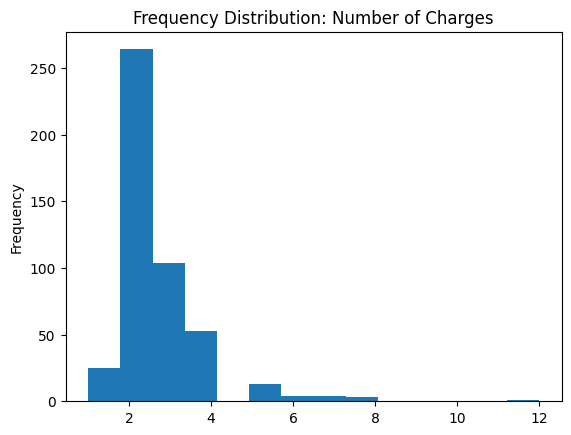

In [52]:
providers.OFFENSES.apply(len).plot(kind='hist', bins=14, title='Frequency Distribution: Number of Charges')

### Q: Are police still charging for "Instruments of crime" in prostitution?
A: Yes. The [Pittsburgh-area campaign](https://www.womenslawproject.org/2018/06/27/a-victory-of-sorts-allegheny-county-police-will-stop-criminalizing-condoms/) to stop criminalizing condoms was at its peak around 2018. Yet somehow, the use of this charge actually increased in 2019. We don't know what specific objects are being seized as the instrument of crime, but phones and condoms are common. 

In [162]:
## Are police still charging "Instrument of crime" alongisde prostitution?
charge = "907"
providers907 = providers[providers.OFFENSES.apply(lambda offs: any(charge in off for off in offs))]
print(len(providers907), "out of", len(providers), "providers were charged with inst of crime")
providers907.YEAR.value_counts(sort=True)


127 out of 471 providers were charged with inst of crime


YEAR
2019    42
2017    28
2020    27
2018    22
2016     6
2021     2
Name: count, dtype: int64

### Q: Did any of the charges involve exploiting minors?
A: Yes. 10 charges involved adults exploiting a minor. Four appear to be providers that solicited a minor. Six appear to be third-parties to prostitution, involved in either trafficking or prostitution-related activity around minors (e.g., running a brothel from a home where a child also lives). 


There are many charges that might be related to the exploitation of minors. Here is a sample of charges related to minors: 
* 5902(b.1) Promoting prostitution of minor
* 6301 Corruption of Minors
* 6318 Unlawful Contact/Communication w/ Minor
* 2910 Luring a Child into a Motor Vehicle.* 3011(b) Trafficking in Minors
* 3131(c)(1) Unlawful dissemination of intimate image -- Person depicted IS a minor UNDER 18 (M1)
* 3126(a)(7) Indecent assault of person under 13
* 4304(a)(1) Endangering Welfare of Children


Separately, at least two people have been arrested for prostitution under the age of 18 (both 17).

In [54]:
charges_minors = [ 
 "5902\s?\(b\.1\)",
 "prostitution of minor", # not sure whether/how they format the b.1 sub-charges
 "6301",
 "6318",
 "2910", 
 "3011\s?\(b\)",
 "Person depicted IS a minor UNDER 18",
 "3126\s?\(a\)\s?\(7\)",
 "4304\s?\(a\)\s?\(1\)"
]

minors_mask = data.OFFENSES_STR.str.contains('|'.join(charges_minors))

print("# of charges that involved minors: ", sum(minors_mask))
data[minors_mask]

# of charges that involved minors:  10


,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,...,rank OFFENSES,ISPROVIDER,ISTHIRDPARTY,ISCLIENT,YEAR,MONTH,OFFENSES_STR,DATE,GROUPARREST,ARRESTSESSION
id,,,,,,,,,,,,,,,,,,,,,
76756,2051324,22140544,24.0,M,W,2022-09-02 10:20:00,Zone 2,"[3121 Rape., 4304(a)(1) Endangering Welfare of Children., 2701(a)(1) Simple Assault - Intent., Know., Reckless.Cause Bod. Injury, 5902(b)(1) Promoting Prostitution - Keeping Business or House, 5902(b)(8) Prostitution - receiving benefit from]",Zone OSC,Unknown,...,0.070624,False,True,False,2022,9,"3121 Rape. / 4304(a)(1) Endangering Welfare of Children. / 2701(a)(1) Simple Assault - Intent., Know., Reckless.Cause Bod. Injury / 5902(b)(1) Promoting Prostitution - Keeping Business or House / 5902(b)(8) Prostitution - receiving benefit from",2022-09-02,1,"(2022-09-02, Zone OSC)"
23137,2003896,18071485,22.0,M,B,2018-08-22 14:10:00,Zone 2,"[6301 Corruption of Minors., 6318 Unlawful Contact/Communication w/ Minor, 5902(b)(1) Promoting Prostitution - Keeping Business or House]",Zone 1,Unknown,...,0.057309,False,True,False,2018,8,6301 Corruption of Minors. / 6318 Unlawful Contact/Communication w/ Minor / 5902(b)(1) Promoting Prostitution - Keeping Business or House,2018-08-22,1,"(2018-08-22, Zone 1)"
60394,2036975,21064275,29.0,M,B,2021-04-22 13:32:00,Zone 6,"[2910 Luring a Child into a Motor Vehicle., 13(a)(16) Possession of Controlled Substance, 13(a)(30) Possession w/ Intent to Del. Controlled Substance, 13(a)(32) Paraphernalia - Use or Possession, 5902(b) Promoting Prostitution, 7512 Criminal Use of Communication, 3011(a)(1) Trafficking in Individuals Recruit/Entice etc, 3011(b) Trafficking in Minors]",Zone 1,Unknown,...,0.057309,False,True,False,2021,4,2910 Luring a Child into a Motor Vehicle. / 13(a)(16) Possession of Controlled Substance / 13(a)(30) Possession w/ Intent to Del. Controlled Substance / 13(a)(32) Paraphernalia - Use or Possession / 5902(b) Promoting Prostitution / 7512 Criminal Use of Communication / 3011(a)(1) Trafficking in Individuals Recruit/Entice etc / 3011(b) Trafficking in Minors,2021-04-22,1,"(2021-04-22, Zone 1)"
19294,1999012,18062017,40.0,F,B,2018-04-13 08:14:00,Zone 5,"[2702 Aggravated Assault., 2705 Recklessy Endangering Another Person., 4304(a)(1) Endangering Welfare of Children., 6301 Corruption of Minors., 5902(b) Promoting Prostitution]",Zone 5,Unknown,...,0.057309,False,True,False,2018,4,2702 Aggravated Assault. / 2705 Recklessy Endangering Another Person. / 4304(a)(1) Endangering Welfare of Children. / 6301 Corruption of Minors. / 5902(b) Promoting Prostitution,2018-04-13,1,"(2018-04-13, Zone 5)"
74246,2048983,22088527,39.0,M,B,2022-06-14 11:00:00,Zone 2,"[3121 Rape., 3123 Involuntary Deviate Sexual Intercourse., 3125 Aggravated Indecent Assault., 3126 Indecent Assault., 5902(a)(1) Prostitution, 3131(c)(1) Unlawful dissemination of intimate image -- Person depicted IS a minor UNDER 18 (M1)]",Zone 1,Unknown,...,0.057309,True,False,False,2022,6,3121 Rape. / 3123 Involuntary Deviate Sexual Intercourse. / 3125 Aggravated Indecent Assault. / 3126 Indecent Assault. / 5902(a)(1) Prostitution / 3131(c)(1) Unlawful dissemination of intimate image -- Person depicted IS a minor UNDER 18 (M1),2022-06-14,4,"(2022-06-14, Zone 1)"
35695,2015709,19126324,37.0,M,W,2019-06-28 03:42:00,Zone 3,"[4304(a)(1) Endangering Welfare of Children., 6301 Corruption of Minors., 13(a)(16) Possession of Controlled Substance, 5902(b)(5) Procuring a prostitute for another]",Zone 3,Unknown,...,0.057309,False,True,False,2019,6,4304(a)(1) Endangering Welfare of Children. / 6301 Corruption of Minors. / 13(a)(16) Possession of Controlled Substance / 5902(b)(5) Procuring a prostitute for another,2019-06-28,2,"(2019-06-28, Zone 3)"
35696,2015710,19126324,34.0,F,B,2019-06-28 02:30:00,Zone 3,"[5902(a)(1) Prostitution, 6301 Corruption of Minors.]",Zone 3,Unknown,...,0.057309,True,False,False,2019,6,5902(a)(1) Prostitution / 6301 Corruption of Minors.,2019-0

In [55]:
## For arrests involving exploitation of minors, was the arrested person charged as a prostitute, third party, or client?
data[["ISPROVIDER", "ISTHIRDPARTY", "ISCLIENT"]][minors_mask].value_counts(dropna=False)

ISPROVIDER  ISTHIRDPARTY  ISCLIENT
False       True          False       6
True        False         False       4
Name: count, dtype: int64

In [56]:
## People under the age of 18 arrested for prostitution
providers.loc[providers.AGE < 18]

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,...,PUBLIC_WORKS_DIVISION,X,Y,rank OFFENSES,ISPROVIDER,ISTHIRDPARTY,ISCLIENT,YEAR,MONTH,OFFENSES_STR
id,,,,,,,,,,,,,,,,,,,,,
7617,1984102,17071348,17.0,F,B,2017-04-20 17:20:00,"Moravian ST & Foreland ST Pittsburgh, PA 15212","[5902(a)(1) Prostitution, 5902(a)(2) Prostitution - Loitering for purpose of]","Moravian ST & Foreland ST Pittsburgh, PA 15212",East Allegheny,...,1,-80.001390,-80.001390,0.070624,True,False,False,2017,4,5902(a)(1) Prostitution / 5902(a)(2) Prostitution - Loitering for purpose of
18605,1998124,18047942,17.0,F,W,2018-03-14 18:21:00,"600 Block Commonwealth PL Pittsburgh, PA 15222",[5902(a)(1) Prostitution],"600 Block Commonwealth PL Pittsburgh, PA 15222",Central Business District,...,6,-80.006405,-80.006405,0.057309,True,False,False,2018,3,5902(a)(1) Prostitution


### Q: Were any charges related to trafficking?

A: Yes, there was one person arrested for trafficking in 2021. 

* 3011(b) Trafficking in Minors
* 3011(a)(1) Trafficking in Individuals Recruit/Entice etc

Aside: The timelines don't exactly match up, but it might be [this guy](https://www.timesonline.com/story/news/crime/2022/06/03/pittsburgh-man-sentenced-to-15-years-for-sex-trafficking-in-moon-township/65358719007/).

In [57]:
charges_trafficking = [ 
    "3011\(b\)",
    "Trafficking in Minors",
    "3011\(a\)\(1\)",
    "Trafficking in Individuals Recruit",
    "3011"
]

trafficking_mask = data.OFFENSES_STR.str.contains('|'.join(charges_trafficking))

print("# of charges that involved trafficking: ", sum(trafficking_mask))
data[trafficking_mask]

# of charges that involved trafficking:  1


,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,...,rank OFFENSES,ISPROVIDER,ISTHIRDPARTY,ISCLIENT,YEAR,MONTH,OFFENSES_STR,DATE,GROUPARREST,ARRESTSESSION
id,,,,,,,,,,,,,,,,,,,,,
60394,2036975,21064275,29.0,M,B,2021-04-22 13:32:00,Zone 6,"[2910 Luring a Child into a Motor Vehicle., 13(a)(16) Possession of Controlled Substance, 13(a)(30) Possession w/ Intent to Del. Controlled Substance, 13(a)(32) Paraphernalia - Use or Possession, 5902(b) Promoting Prostitution, 7512 Criminal Use of Communication, 3011(a)(1) Trafficking in Individuals Recruit/Entice etc, 3011(b) Trafficking in Minors]",Zone 1,Unknown,...,0.057309,False,True,False,2021,4,2910 Luring a Child into a Motor Vehicle. / 13(a)(16) Possession of Controlled Substance / 13(a)(30) Possession w/ Intent to Del. Controlled Substance / 13(a)(32) Paraphernalia - Use or Possession / 5902(b) Promoting Prostitution / 7512 Criminal Use of Communication / 3011(a)(1) Trafficking in Individuals Recruit/Entice etc / 3011(b) Trafficking in Minors,2021-04-22,1,"(2021-04-22, Zone 1)"


### Q: Overall, how many arrests involve violence or coercion?

A: Only 3% of arrests included charges related to violence or coercion (including rape, trafficking, assault, exploitation of minors). This suggests that the current system of policing often targets scenarios where violence isn't a risk.  

Charges included
* 3121 Rape.
* 2702 Aggravated Assault.
* 3126 Indecent Assault.
* 3123 Involuntary Deviate Sexual Intercourse.
* 2718(a)(1) Strangulation - Applying Pressure to the Throat or Neck
* 3125 Aggravated Indecent Assault.   
* 3126(a)(4) Indecent assault of unconscious person
* 2701(a)(1) Simple Assault - Intent., Know., Reckless.Cause Bod. Injury
* 2701 Simple Assault.
* 7507.1 Invasion Privacy - Victim Full or Part Nude
* 3124.1 Sexual Assault
* 3121(a)(3) Rape of unconscious person
* 3123(a)(3) IDSI with unconscious person
* 3011(a)(1) Trafficking in Individuals Recruit/Entice etc
* any charges related to trafficking or coercion of minors (listed elsewhere)

Note: This list of charges isn't exhaustive of all violent/coercive crimes, just the ones represented in this dataset. The formal definition of "violent crime" in arrest data usually focuses on homicides and gun violence; I'm using a broader, hand-curated list here.

In [74]:
charges_violence = [
"3121 Rape",
"2702 Aggravated Assault",
"3126 Indecent Assault",
"3123 Involuntary Deviate Sexual Intercourse,"
"2718\(a\)\(1\) Strangulation",
"3125 Aggravated Indecent Assault",   
"3126\(a\)\(4\) Indecent assault of unconscious person",
"2701\(a\)\(1\) Simple Assault",
"2701 Simple Assault",
"7507.1 Invasion Privacy",
"3124.1 Sexual Assault",
"3121\(a\)\(3\) Rape of unconscious person",
"3123\(a\)\(3\) IDSI with unconscious person",
]

charges_coercion = [
"3131\(c\)\(2\) Unlawful dissemination of intimate image",
"2709\(a\)\(1\) Harassment by Physical Contact, or Attempts or Threats",
]


charges_violence = charges_violence + charges_coercion + charges_trafficking + charges_minors
violent_mask = data.OFFENSES_STR.str.contains('|'.join(charges_violence))

print("# of arrests that involved violence/coercion: ", sum(violent_mask), " of ", len(data))
data[violent_mask]

# of arrests that involved violence/coercion:  22  of  695


,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,...,rank OFFENSES,ISPROVIDER,ISTHIRDPARTY,ISCLIENT,YEAR,MONTH,OFFENSES_STR,DATE,GROUPARREST,ARRESTSESSION
id,,,,,,,,,,,,,,,,,,,,,
73054,2047953,22063258,39.0,M,B,2022-05-18 11:30:00,Zone 1,"[3304 Criminal Mischief., 5902(a)(1) Prostitution, 3124.1 Sexual Assault, 5902(b) Promoting Prostitution, 5902(b)(1) Promoting Prostitution - Keeping Business or House, 5902(b)(3) Promoting Prostitution - Causing another to become or remain, 5902(b)(7) Permitting place to be regularly used for prostitution, 5902(b)(8) Prostitution - receiving benefit from, 3121(a)(3) Rape of unconscious person, 3123(a)(3) IDSI with unconscious person, 3126(a)(4) Indecent assault of unconscious person, 3131(c)(2) Unlawful dissemination of intimate image -- Person depicted is NOT a minor (M2)]",Zone 1,Unknown,...,0.083129,True,True,False,2022,5,3304 Criminal Mischief. / 5902(a)(1) Prostitution / 3124.1 Sexual Assault / 5902(b) Promoting Prostitution / 5902(b)(1) Promoting Prostitution - Keeping Business or House / 5902(b)(3) Promoting Prostitution - Causing another to become or remain / 5902(b)(7) Permitting place to be regularly used for prostitution / 5902(b)(8) Prostitution - receiving benefit from / 3121(a)(3) Rape of unconscious person / 3123(a)(3) IDSI with unconscious person / 3126(a)(4) Indecent assault of unconscious person / 3131(c)(2) Unlawful dissemination of intimate image -- Person depicted is NOT a minor (M2),2022-05-18,1,"(2022-05-18, Zone 1)"
74243,2048980,22088525,39.0,M,B,2022-06-14 10:45:00,Zone 2,"[3121 Rape., 5902(b)(1) Promoting Prostitution - Keeping Business or House, 5902(b)(3) Promoting Prostitution - Causing another to become or remain, 5902(b)(7) Permitting place to be regularly used for prostitution, 5902(b)(8) Prostitution - receiving benefit from, 3126(a)(4) Indecent assault of unconscious person]",Zone 1,Unknown,...,0.079652,False,True,False,2022,6,3121 Rape. / 5902(b)(1) Promoting Prostitution - Keeping Business or House / 5902(b)(3) Promoting Prostitution - Causing another to become or remain / 5902(b)(7) Permitting place to be regularly used for prostitution / 5902(b)(8) Prostitution - receiving benefit from / 3126(a)(4) Indecent assault of unconscious person,2022-06-14,4,"(2022-06-14, Zone 1)"
29054,2009980,18209726,42.0,F,W,2018-12-22 16:55:00,"900 Block Second AV Pittsburgh, PA 15219","[2702 Aggravated Assault., 2705 Recklessy Endangering Another Person., 5104 Resisting Arrest or Other Law Enforcement., 5121 Escape., 5902(a)(1) Prostitution, 13(a)(32) Paraphernalia - Use or Possession, 5902(a)(2) Prostitution - Loitering for purpose of]","Forbes AV & Moultrie ST Pittsburgh, PA 15219",Bluff,...,0.070624,True,False,False,2018,12,2702 Aggravated Assault. / 2705 Recklessy Endangering Another Person. / 5104 Resisting Arrest or Other Law Enforcement. / 5121 Escape. / 5902(a)(1) Prostitution / 13(a)(32) Paraphernalia - Use or Possession / 5902(a)(2) Prostitution - Loitering for purpose of,2018-12-22,1,"(2018-12-22, Forbes AV & Moultrie ST Pittsburgh, PA 15219)"
76756,2051324,22140544,24.0,M,W,2022-09-02 10:20:00,Zone 2,"[3121 Rape., 4304(a)(1) Endangering Welfare of Children., 2701(a)(1) Simple Assault - Intent., Know., Reckless.Cause Bod. Injury, 5902(b)(1) Promoting Prostitution - Keeping Business or House, 5902(b)(8) Prostitution - receiving benefit from]",Zone OSC,Unknown,...,0.070624,False,True,False,2022,9,"3121 Rape. / 4304(a)(1) Endangering Welfare of Children. / 2701(a)(1) Simple Assault - Intent., Know., Reckless.Cause Bod. Injury / 5902(b)(1) Promoting Prostitution - Keeping Business or House / 5902(b)(8) Prostitution - receiving benefit from",2022-09-02,1,"(2022-09-02, Zone OSC)"
6674,1982939,17050226,25.0,M,B,2017-03-20 19:03:00,"2700 Block S Water ST Pittsburgh, PA 15203","[907 Possessing Instruments of Crime., 2702 Aggravated Assault., 5104 Resisting Arrest or Other Law Enforcement., 5902(a)(1) Prostitution, 13(a)(31)

### Q: Did any charges involve the criminalization of HIV? 
A: We don't know. If there were charges that increased the grading of prostitution, they are not represented in the data.  

Note: [5901(a.1)(4)](https://www.legis.state.pa.us/WU01/LI/LI/CT/HTM/18/00.059.002.000..HTM) increases the grading of a prostitution charge to a "Felony of the third degree if the person who committed the offense knew that" they have HIV/AIDS. This is also true if a patron has HIV/AIDS or a third-party promoted the prostitution of someone with HIV/AIDS.

In [58]:
charges_HIV = [ 
    "HIV",
    "AIDS",
    "a/.1",
    "5902/(c/)",
    "e/.1",
]

HIV_mask = data.OFFENSES_STR.str.contains('|'.join(charges_HIV))

print("# of charges that might involve HIV: ", sum(HIV_mask))
#data[HIV_mask]

# of charges that might involve HIV:  0


C:\Users\oates\AppData\Local\Temp\ipykernel_59580\2132990508.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  HIV_mask = data.OFFENSES_STR.str.contains('|'.join(charges_HIV))


### Q: Did any charges involve drug use? 
A: .  

Charges considered include:
* 13(a) main code
* 13(a)(30) Possession w/ Intent to Del. Controlled Substance
* 13(a)(32) Paraphernalia - Use or Possession
* 13(a)(30)* Delivery of Controlled Substance
* 13(a)(31)* Hashish - Possession Small Amount
* 13(a)(31) is minor possession of marijuana
* 13(a)(31)(i) Marijuana - Possess Small Amt for Personal Use

 If we separate out minor possession of marijuana, we're left with:
* 13(a)(30) Possession w/ Intent to Del. Controlled Substance
* 13(a)(30)* Delivery of Controlled Substance
* should Paraphernalia be included here? I don't think so? 

Note: this list excludes "5123 Contraband," a charge that covers the posession of drugs, money, or phones for incarcerated people.
out) 



In [76]:
drug_charges = [
    "13\(a\)",
    "13\(a\)\(30\) Possession w",
    "13\(a\)\(32\) Paraphernalia - Use or Possession",
    "Delivery of Controlled Substance",
    "13\(a\)\(31\)? Hashish - Possession Small Amount",
    "13\(a\)\(31\) is minor possession of marijuana",
    "13\(a\)\(31\)\(i\) Marijuana - Possess Small Amt for Personal Use",
]
    
minor_weed = [
    "13\(a\)\(31\)? Hashish - Possession Small Amount",
    "13\(a\)\(31\) is minor possession of marijuana",
    "13\(a\)\(31\)\(i\) Marijuana - Possess Small Amt for Personal Use",
    ]

drug_mask = data.OFFENSES_STR.str.contains('|'.join(drug_charges))

print("# of arrests that involved drugs: ", sum(drug_mask), " of ", len(data))
#data[drug_mask]

# of arrests that involved drugs:  126  of  695


,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,...,rank OFFENSES,ISPROVIDER,ISTHIRDPARTY,ISCLIENT,YEAR,MONTH,OFFENSES_STR,DATE,GROUPARREST,ARRESTSESSION
id,,,,,,,,,,,,,,,,,,,,,
35966,2015942,19129796,25.0,M,B,2019-07-02 21:25:00,"100 Block Washington PL Pittsburgh, PA 15219","[903 Criminal Conspiracy., 13(a)(31) Marijuana: Possession Small Amount, 5902(b) Promoting Prostitution, 5902(b)(6) Transporting for the purpose of engaging in prostitution, 5902(b)(8) Prostitution - receiving benefit from]","100 Block Washington PL Pittsburgh, PA 15219",Central Business District,...,0.076422,False,True,False,2019,7,903 Criminal Conspiracy. / 13(a)(31) Marijuana: Possession Small Amount / 5902(b) Promoting Prostitution / 5902(b)(6) Transporting for the purpose of engaging in prostitution / 5902(b)(8) Prostitution - receiving benefit from,2019-07-02,7,"(2019-07-02, 100 Block Washington PL Pittsburgh, PA 15219)"
22452,2003041,18137854,49.0,M,W,2018-07-19 20:15:00,"200 Block Station Square DR W Pittsburgh, PA 15219","[903 Criminal Conspiracy., 13(a)(16) Possession of Controlled Substance, 13(a)(32) Paraphernalia - Use or Possession, 5902(b)(1) Promoting Prostitution - Keeping Business or House, 5902(b)(6) Transporting for the purpose of engaging in prostitution, 5902(b)(8) Prostitution - receiving benefit from]","200 Block Station Square DR Pittsburgh, PA 15219",South Shore,...,0.076422,False,True,False,2018,7,903 Criminal Conspiracy. / 13(a)(16) Possession of Controlled Substance / 13(a)(32) Paraphernalia - Use or Possession / 5902(b)(1) Promoting Prostitution - Keeping Business or House / 5902(b)(6) Transporting for the purpose of engaging in prostitution / 5902(b)(8) Prostitution - receiving benefit from,2018-07-19,2,"(2018-07-19, 200 Block Station Square DR Pittsburgh, PA 15219)"
54046,2031349,20183214,40.0,M,B,2020-09-30 19:40:00,"100 Block Washington PL Pittsburgh, PA 15219","[903 Criminal Conspiracy., 907 Possessing Instruments of Crime., 5902(a)(1) Prostitution, 13(a)(16) Possession of Controlled Substance, 13(a)(30) Possession w/ Intent to Del. Controlled Substance, 13(a)(32) Paraphernalia - Use or Possession, 5902(b)(6) Transporting for the purpose of engaging in prostitution, 5902(b)(8) Prostitution - receiving benefit from]","100 Block Washington PL Pittsburgh, PA 15219",Central Business District,...,0.076422,True,True,False,2020,9,903 Criminal Conspiracy. / 907 Possessing Instruments of Crime. / 5902(a)(1) Prostitution / 13(a)(16) Possession of Controlled Substance / 13(a)(30) Possession w/ Intent to Del. Controlled Substance / 13(a)(32) Paraphernalia - Use or Possession / 5902(b)(6) Transporting for the purpose of engaging in prostitution / 5902(b)(8) Prostitution - receiving benefit from,2020-09-30,5,"(2020-09-30, 100 Block Washington PL Pittsburgh, PA 15219)"
193,1974657,16149572,40.0,F,W,2016-08-11 08:21:00,"Coral ST & S Pacific AV Pittsburgh, PA 15224","[5902(a)(1) Prostitution, 13(a)(16) Possession of Controlled Substance, 5902(a)(2) Prostitution - Loitering for purpose of]","Coral ST & S Pacific AV Pittsburgh, PA 15224",Bloomfield,...,0.070624,True,False,False,2016,8,5902(a)(1) Prostitution / 13(a)(16) Possession of Controlled Substance / 5902(a)(2) Prostitution - Loitering for purpose of,2016-08-11,1,"(2016-08-11, Coral ST & S Pacific AV Pittsburgh, PA 15224)"
74174,2048938,20191330,NaN,F,B,2020-10-13 07:25:00,"7500 Block Meade ST Pittsburgh, PA 15208","[5902(a)(1) Prostitution, 13(a)(32) Paraphernalia - Use or Possession, 5902(a)(2) Prostitution - Loitering for purpose of]","N Homewood AV & Frankstown AV Pittsburgh, PA 15208",Homewood North,...,0.070624,True,False,False,2020,10,5902(a)(1) Prostitution / 13(a)(32) Paraphernalia - Use or Possession / 5902(a)(2) Prostitution - Loitering for purpose of,2020-10-13,2,"(2020-10-13, N Homewood AV & Frankstown AV Pittsburgh, PA 15208)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4739,19

In [77]:
# TODO: exclude minor possession charges from the regex!


maybe TODO: General violent charges, eg rape, assault
3123 Involuntary Deviate Sexual Intercourse.                                 4

# Questions - what are the demographics of people arrested for patronizing prostitution?